In [ ]:
!pip install pydantic

## Load corpus

In [6]:
from globals import CORPUS_PATH
from utils import load_corpus

In [7]:
corpus = load_corpus(CORPUS_PATH)
corpus[:1]

[{'id': 1,
  'category': 'business',
  'content': 'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the

In [31]:
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from gensim import corpora, models, similarities
from operator import itemgetter

from models import Corpus, Result
from utils import print_resuts

class TFIDFModel:
    def __init__(self, corpus:Corpus, path='/tmp/vsm_docs.mm'):
        self.corpus = corpus
        self.path = path
        self.stopset = set(stopwords.words('english'))
        self.dictionary = self.create_dictionary()
        self.docs2bows()
        self.loaded_corpus = corpora.MmCorpus(path)
        self.tfidf = models.TfidfModel(self.loaded_corpus)
        self.index = similarities.MatrixSimilarity(self.loaded_corpus, num_features=len(self.dictionary))


    def preprocess(self, doc):
        stemmer = PorterStemmer()
        tokens = wordpunct_tokenize(doc)
        clean = [token.lower() for token in tokens if token.lower() not in self.stopset and len(token) > 2]
        final = [stemmer.stem(word) for word in clean]
        return final

    def create_dictionary(self):
        pdocs = [self.preprocess(doc["content"]) for doc in self.corpus]
        dictionary = corpora.Dictionary(pdocs)
        dictionary.save('/tmp/dictionary.dict')  # Saving to a specific path
        return dictionary

    def docs2bows(self):
        docs = [self.preprocess(doc['content']) for doc in self.corpus]
        vectors = [self.dictionary.doc2bow(doc) for doc in docs]
        corpora.MmCorpus.serialize(self.path, vectors)
        
    def get_model(self):
        return self.tfidf, self.dictionary

    def calculate_query_vector(self, q:str):
        pq = self.preprocess(q)
        vq = self.dictionary.doc2bow(pq)
        qtfidf = self.tfidf[vq]
        return qtfidf
    
    def launch_query(self, q, k=5):
        qtfidf = self.calculate_query_vector(q)
        sim = self.index[qtfidf]
        ranking = sorted(enumerate(sim), key=itemgetter(1), reverse=True)
        results = [ Result(id=self.corpus[idx]['id'], content=self.corpus[idx]['content'], category=self.corpus[idx]['category'], score=score)  for idx, score in ranking ]
        print_resuts(results[:k])

        return results

In [32]:
model = TFIDFModel(corpus)

In [33]:
results = model.launch_query("business")

 1. [ Score = 0.506 ] Category politics |  ID: 1423 | Text: uk firms  embracing e-commerce  uk firms are embra
 2. [ Score = 0.350 ] Category business |  ID: 185 | Text: businesses fail to plan for hiv companies fail to 
 3. [ Score = 0.244 ] Category business |  ID: 1151 | Text: rank  set to sell off film unit  leisure group ran
 4. [ Score = 0.243 ] Category business |  ID: 852 | Text: japanese mogul arrested for fraud one of japan s b
 5. [ Score = 0.233 ] Category business |  ID: 1593 | Text: crossrail link  to get go-ahead  the £10bn crossra


In [34]:
print(results[0])

Document ID: 1423, Category: politics, Score: 0.51
Content: uk firms  embracing ...


In [35]:
print(len(results))

2225


# Evaluation

In [36]:
from evaltools import evaluate

In [37]:
categories = ['politics', 'entertainment', 'sport', 'tech', 'business']

In [38]:
method_1 = 'prec_rec' 
method_2 = 'r-prec'
method_3 = 'map'

In [39]:
import json 
from globals import WORDS_PATH, WORDS_CHAT_PATH

In [40]:
from utils import process_results
from models import Query

## Results One word 

In [41]:
queries_normal = [ Query(category=c, content=c) for c in categories]
queries_normal

[Query(category='politics', content='politics'),
 Query(category='entertainment', content='entertainment'),
 Query(category='sport', content='sport'),
 Query(category='tech', content='tech'),
 Query(category='business', content='business')]

Query 1: category='politics' content='politics'
 1. [ Score = 0.395 ] Category tech |  ID: 982 | Text: online games play with politics after bubbling und
 2. [ Score = 0.331 ] Category sport |  ID: 2111 | Text: kennedy predicts bigger turnout voters   pent up p
 3. [ Score = 0.281 ] Category politics |  ID: 914 | Text: choose hope over fear - kennedy voters will have a
 4. [ Score = 0.254 ] Category sport |  ID: 1801 | Text: teens  know little  of politics teenagers question
 5. [ Score = 0.244 ] Category politics |  ID: 124 | Text: debate needed  on donations cap a cap on donations
-----
Query 2: category='entertainment' content='entertainment'
 1. [ Score = 0.260 ] Category entertainment |  ID: 888 | Text: music mogul fuller sells company pop idol supremo 
 2. [ Score = 0.162 ] Category politics |  ID: 1800 | Text: bbc to pour £9m into new comedy the bbc is to inve
 3. [ Score = 0.142 ] Category entertainment |  ID: 1794 | Text: news corp makes $5.4bn fox offer news corporation 
 4. 

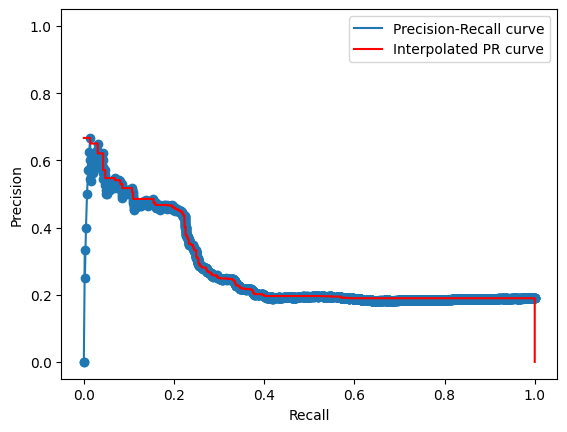

	Query 2


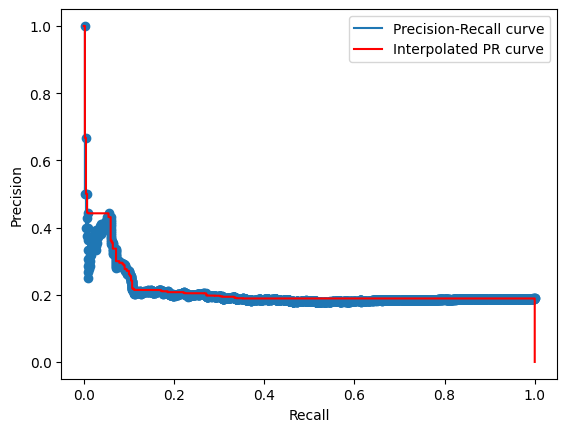

	Query 3


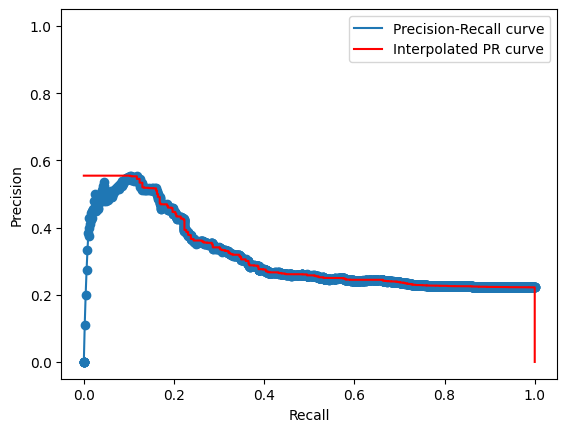

	Query 4


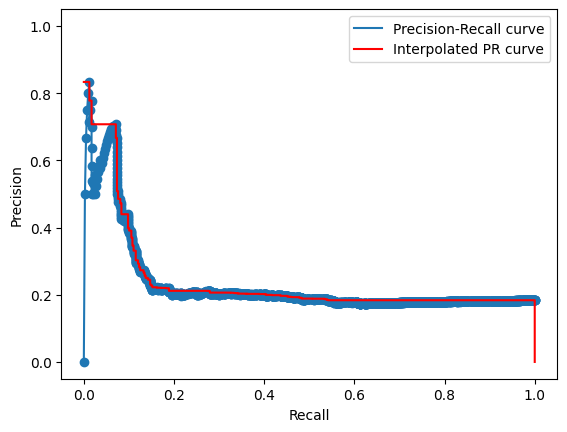

	Query 5


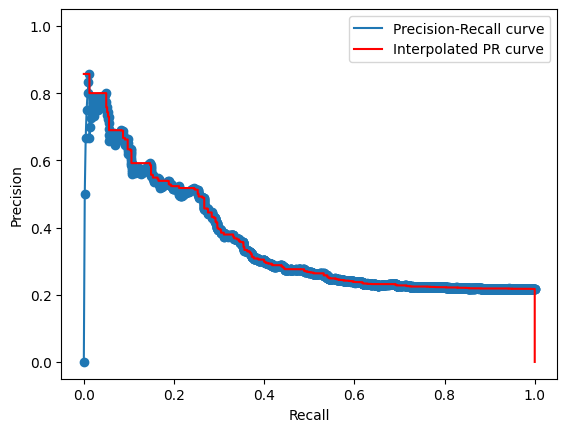

In [42]:
results, relevances = process_results(model, queries_normal)
evaluate(method_1, results, relevances, True)

In [43]:
print("Method:", method_2)
evaluate(method_2, results, relevances, False)
print("Method:", method_3)
evaluate(method_3, results, relevances, False)

Method: r-prec

 Determine R-precision for each query
	Query 1
		Number of relevant documents: 421 --> P(421)=0.27
	Query 2
		Number of relevant documents: 420 --> P(420)=0.20
	Query 3
		Number of relevant documents: 493 --> P(493)=0.32
	Query 4
		Number of relevant documents: 408 --> P(408)=0.20
	Query 5
		Number of relevant documents: 483 --> P(483)=0.35
Method: map

 Calculate the Mean Average Precision
	Query 1
		AP=1/421 {P(3) + P(5) + P(6) + P(7) + P(8) + P(9) + P(12) + P(14) + P(15) + P(17) + P(18) + P(19) + P(20) + P(23) + P(25) + P(27) + P(28) + P(29) + P(34) + P(35) + P(39) + P(43) + P(45) + P(46) + P(48) + P(49) + P(50) + P(52) + P(53) + P(57) + P(58) + P(60) + P(61) + P(63) + P(67) + P(68) + P(75) + P(76) + P(77) + P(78) + P(80) + P(82) + P(85) + P(86) + P(87) + P(91) + P(98) + P(105) + P(106) + P(107) + P(109) + P(111) + P(113) + P(115) + P(116) + P(117) + P(119) + P(120) + P(123) + P(127) + P(130) + P(131) + P(132) + P(133) + P(134) + P(139) + P(142) + P(147) + P(149) + P

## Results Max word

In [ ]:
with open(WORDS_PATH) as f:
    max_words = json.load(f)

In [ ]:
queries_max = [ Query(category=c, content=" ".join(max_words[c])) for c in categories]
queries_max

In [ ]:
results, relevances = process_results(model, queries_max)
evaluate(method_1, results, relevances)

In [ ]:
print("Method:", method_2)
evaluate(method_2, results, relevances, False)
print("Method:", method_3)
evaluate(method_3, results, relevances, False)

method='prec_rec' 
evaluate(method,Q,R)

## Results synonyms chat gpt

In [44]:
with open(WORDS_CHAT_PATH) as f:
    synonyms = json.load(f)

In [45]:
queries_chat = [Query(category=c, content=" ".join(synonyms[c]) + " " + c) for c in categories]
queries_chat

[Query(category='politics', content='government governance statecraft diplomacy ideology policy current affairs public affairs civics activism politics'),
 Query(category='entertainment', content='amusement fun leisure diversion recreation pastime show business performing arts media pop culture entertainment'),
 Query(category='sport', content='play game athletics games competition exercise fitness recreation pastime league championship olympics sport'),
 Query(category='tech', content='technology innovation engineering science gadgets devices software hardware internet digital tech'),
 Query(category='business', content='commerce industry trade enterprise company corporation finance economics market profession business')]

Query 1: category='politics' content='government governance statecraft diplomacy ideology policy current affairs public affairs civics activism politics'
 1. [ Score = 0.154 ] Category tech |  ID: 775 | Text: online commons to spark debate online communities 
 2. [ Score = 0.118 ] Category sport |  ID: 1846 | Text: whitehall shredding increasing - tories civil serv
 3. [ Score = 0.104 ] Category politics |  ID: 106 | Text: talks aim to avert pension strike talks aimed at a
 4. [ Score = 0.104 ] Category politics |  ID: 530 | Text: talks aim to avert pension strike talks aimed at a
 5. [ Score = 0.100 ] Category politics |  ID: 67 | Text: stalemate in pension strike talks talks aimed at a
-----
Query 2: category='entertainment' content='amusement fun leisure diversion recreation pastime show business performing arts media pop culture entertainment'
 1. [ Score = 0.119 ] Category entertainment |  ID: 1179 | Text: top of the pops leaves bbc one the bbc s flagship 
 2. [ Score = 0.094 ] Ca

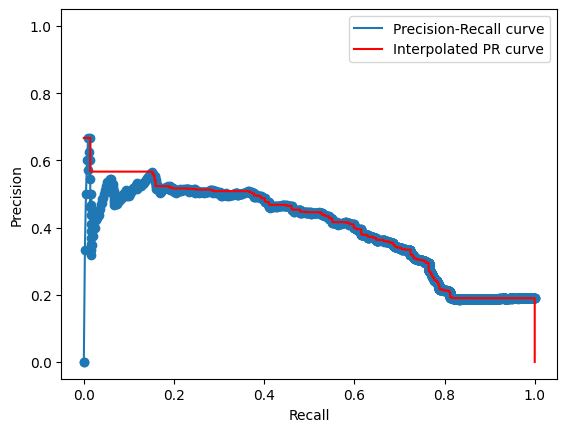

	Query 2


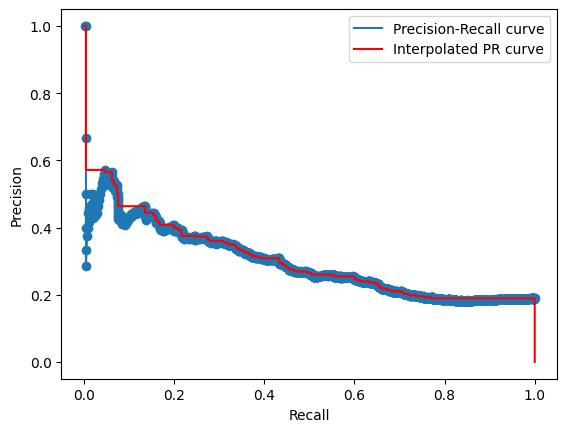

	Query 3


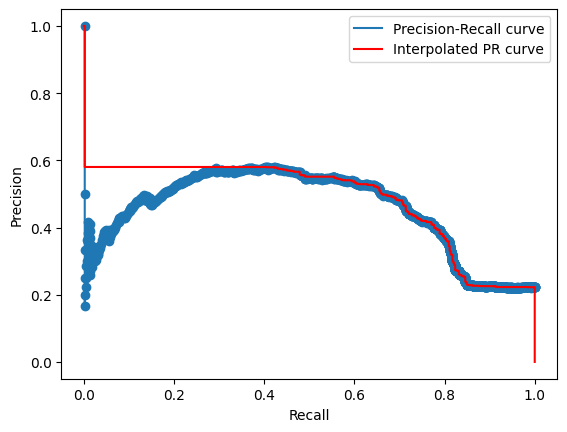

	Query 4


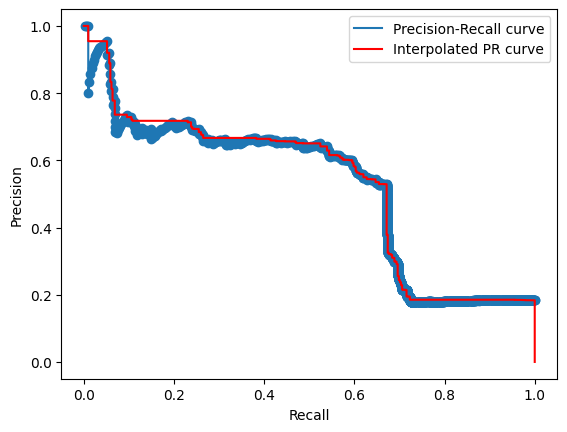

	Query 5


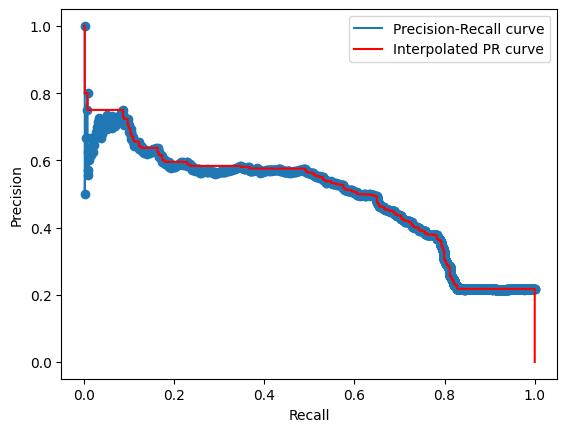

In [46]:
results, relevances = process_results(model, queries_chat)
evaluate(method_1, results, relevances)

In [47]:
print("Method:", method_2)
evaluate(method_2, results, relevances, False)
print("Method:", method_3)
evaluate(method_3, results, relevances, False)

Method: r-prec

 Determine R-precision for each query
	Query 1
		Number of relevant documents: 421 --> P(421)=0.46
	Query 2
		Number of relevant documents: 420 --> P(420)=0.34
	Query 3
		Number of relevant documents: 493 --> P(493)=0.55
	Query 4
		Number of relevant documents: 408 --> P(408)=0.60
	Query 5
		Number of relevant documents: 483 --> P(483)=0.54
Method: map

 Calculate the Mean Average Precision
	Query 1
		AP=1/421 {P(3) + P(4) + P(5) + P(6) + P(8) + P(9) + P(14) + P(23) + P(24) + P(25) + P(26) + P(27) + P(29) + P(31) + P(33) + P(34) + P(35) + P(37) + P(38) + P(39) + P(40) + P(41) + P(43) + P(44) + P(46) + P(50) + P(51) + P(55) + P(61) + P(62) + P(65) + P(67) + P(68) + P(70) + P(71) + P(73) + P(74) + P(75) + P(76) + P(80) + P(82) + P(83) + P(86) + P(87) + P(88) + P(89) + P(91) + P(92) + P(93) + P(94) + P(98) + P(99) + P(100) + P(102) + P(103) + P(105) + P(106) + P(107) + P(108) + P(109) + P(110) + P(111) + P(112) + P(113) + P(116) + P(119) + P(124) + P(131) + P(132) + P(136)

# Test over two categories

We have 3 users:
1. Interested in Sport and Politics
2. Interested in Tech and Business
3. Interested in Sport and Entertainment

In [55]:
users = {1: "I am interested in Sport and Politics", 2: "I am interested in Tech and Business", 3: "I am interested in Sport and Entertainment"}

In [56]:
res = model.launch_query(users[1], k=10)

 1. [ Score = 0.338 ] Category politics |  ID: 1282 | Text: school sport  is back   says pm tony blair has pro
 2. [ Score = 0.327 ] Category politics |  ID: 861 | Text: tories pledge free sports lessons children would b
 3. [ Score = 0.261 ] Category sport |  ID: 2111 | Text: kennedy predicts bigger turnout voters   pent up p
 4. [ Score = 0.259 ] Category tech |  ID: 421 | Text: piero gives rugby perspective bbc sport unveils it
 5. [ Score = 0.236 ] Category tech |  ID: 982 | Text: online games play with politics after bubbling und
 6. [ Score = 0.214 ] Category politics |  ID: 1685 | Text: sporting rivals go to extra time the current slew 
 7. [ Score = 0.208 ] Category business |  ID: 2223 | Text: sport betting rules in spotlight a group of mps an
 8. [ Score = 0.195 ] Category sport |  ID: 254 | Text: adriano s chelsea link rejected adriano s agent gi
 9. [ Score = 0.192 ] Category sport |  ID: 1801 | Text: teens  know little  of politics teenagers question
 10. [ Score = 0.167 ]

User 1: 
- $ P@5 = 3/5 $
- $P@10 = 7/10 $

In [57]:
res = model.launch_query(users[2], k=10)

 1. [ Score = 0.203 ] Category politics |  ID: 1423 | Text: uk firms  embracing e-commerce  uk firms are embra
 2. [ Score = 0.147 ] Category business |  ID: 423 | Text: economy  strong  in election year uk businesses ar
 3. [ Score = 0.147 ] Category business |  ID: 1459 | Text: economy  strong  in election year uk businesses ar
 4. [ Score = 0.141 ] Category business |  ID: 185 | Text: businesses fail to plan for hiv companies fail to 
 5. [ Score = 0.127 ] Category business |  ID: 389 | Text: bargain calls widen softbank loss japanese communi
 6. [ Score = 0.124 ] Category politics |  ID: 2080 | Text: technology gets the creative bug the hi-tech and t
 7. [ Score = 0.124 ] Category business |  ID: 2 | Text: german business confidence slides german business 
 8. [ Score = 0.111 ] Category business |  ID: 1928 | Text: fed warns of more us rate rises the us looks set f
 9. [ Score = 0.101 ] Category business |  ID: 595 | Text: executive trio leave aer lingus three senior execu
 10. [ S

User 2: 
- $ P@5 = 4/5 $
- $P@10 = 8/10 $

In [58]:
res = model.launch_query(users[3], k=10)

 1. [ Score = 0.307 ] Category politics |  ID: 1282 | Text: school sport  is back   says pm tony blair has pro
 2. [ Score = 0.297 ] Category politics |  ID: 861 | Text: tories pledge free sports lessons children would b
 3. [ Score = 0.261 ] Category tech |  ID: 421 | Text: piero gives rugby perspective bbc sport unveils it
 4. [ Score = 0.241 ] Category politics |  ID: 1685 | Text: sporting rivals go to extra time the current slew 
 5. [ Score = 0.239 ] Category entertainment |  ID: 888 | Text: music mogul fuller sells company pop idol supremo 
 6. [ Score = 0.189 ] Category business |  ID: 2223 | Text: sport betting rules in spotlight a group of mps an
 7. [ Score = 0.177 ] Category sport |  ID: 254 | Text: adriano s chelsea link rejected adriano s agent gi
 8. [ Score = 0.142 ] Category politics |  ID: 1535 | Text: collins named uk athletics chief uk athletics has 
 9. [ Score = 0.131 ] Category tech |  ID: 370 | Text: bbc leads interactive bafta wins the bbc and the n
 10. [ Score

User 3: 
- $ P@5 = 1/5 $
- $P@10 = 2/10 $